In [28]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import requests
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Cordia New'
plt.rc('axes', unicode_minus=False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,}'.format



In [29]:

url_loan = "https://data.go.th/dataset/ee2d5c24-e132-48fa-b7dd-254b281440d7/resource/55c6fc3b-ce11-4f45-8a63-fa5cb9cd67fd/download/2564-2565-66.xlsx"
url_payer = "https://data.go.th/dataset/1f36630a-c9d2-4ee6-86ea-4f7f93af4761/resource/58e64a92-7b1f-4453-bc8e-f7397c5a9606/download/untitled.xlsx"
url_status = "https://data.go.th/dataset/191983d1-3e59-4bf1-8d6d-6f5cb5c54c8f/resource/551865fe-7277-4213-b307-3cd374270441/download/_66.xlsx"

# Data preparation

## ข้อมูลผลการกู้ กยศ แยกตามพื้นที่ปี 2564 - 2565


In [117]:
df_loan = pd.read_excel(url_loan)
# df_loan.head()

# เพิ่มคอลัมน์ ผลรวมการกู้

df_loan['ผลรวมการกู้'] = df_loan['จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง']+ df_loan['จำนวนเงินค่าครองชีพ']
df_loan = df_loan[df_loan['ปีการศึกษา'] != 2564]
df_loan = df_loan.drop(['ลักษณะการกู้ยืม','ตำบล','อำเภอ','ปีการศึกษา'],axis=1)
summed_df_loan = df_loan.groupby('จังหวัด').sum().reset_index()
summed_df_loan.head()

,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,จำนวนผู้กู้ยืมค่าครองชีพ,จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง,จำนวนเงินค่าครองชีพ,ผลรวมการกู้
0,กระบี่,6694,6545,"178,467,861.0",210918000,"389,385,861.0"
1,กรุงเทพมหานคร,38874,33705,"1,600,045,662.0",1108494000,"2,708,539,662.0"
2,กาญจนบุรี,7122,6884,"171,206,212.0",219930000,"391,136,212.0"
3,กาฬสินธุ์,9361,9051,"227,678,498.0",288254400,"515,932,898.0"
4,กำแพงเพชร,7239,6990,"150,393,152.0",219867600,"370,260,752.0"


In [118]:
summed_df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   จังหวัด                                      77 non-null     object 
 1   จำนวนผู้กู้ยืมทั้งหมด                        77 non-null     int64  
 2   จำนวนผู้กู้ยืมค่าครองชีพ                     77 non-null     int64  
 3   จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง  77 non-null     float64
 4   จำนวนเงินค่าครองชีพ                          77 non-null     int64  
 5   ผลรวมการกู้                                  77 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.7+ KB


## คำอธิบายเพิ่มเติม
ข้อมูลเชิงกลุ่มที่ต้องการการอธิบาย : **ลักษณะการกู้ยืม**
* 1 หมายถึง ขาดแคลนทุนทรัพย์
* 2 หมายถึง ศึกษาในสาขาวิชาที่เป็นวามต้องการหลัก
* 3 หมายถึง ศึกษาในสาขาวิชาขาดแคลน
* 4 หมายถึง เรียนดี

## ข้อมูลประเภทของผู้กู้ กยศ ของแต่ละพื้นที่ แยกตามสถานะปลอดหนี้และสถานะชำระหนี้ 2564 - 2565 


In [33]:
df_payer = pd.read_excel(url_payer)
df_payer = df_payer[df_payer['ปีงบประมาณ'] != 2564]
df_payer = df_payer.drop(['ลักษณะการให้กู้ยืม','ตำบล','อำเภอ','ปีงบประมาณ'],axis=1)
df_payer.head()

,สถานะผู้กู้,จังหวัด,จำนวนผู้กู้,จำนวนเงินกู้
29240,อยู่ระหว่างชำระหนี้,กระบี่,658,"92,033,565.22"
29241,อยู่ระหว่างชำระหนี้,กระบี่,391,"54,801,093.67"
29242,อยู่ระหว่างชำระหนี้,กระบี่,355,"47,756,918.55"
29243,อยู่ระหว่างชำระหนี้,กระบี่,414,"54,755,402.16"
29244,อยู่ระหว่างชำระหนี้,กระบี่,306,"46,195,512.96"


In [114]:
df_payer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29674 entries, 29240 to 58913
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   สถานะผู้กู้   29674 non-null  object 
 1   จังหวัด       29674 non-null  object 
 2   จำนวนผู้กู้   29674 non-null  int64  
 3   จำนวนเงินกู้  29674 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [35]:
# จัดกลุ่มข้อมูลแยกตามจังหวัดและสถานะผู้กู้

grouped_df_payer = df_payer.groupby(['จังหวัด','สถานะผู้กู้']).sum().reset_index()
grouped_df_payer.head(6)

,จังหวัด,สถานะผู้กู้,จำนวนผู้กู้,จำนวนเงินกู้
0,กระบี่,อยู่ระหว่างชำระหนี้,24429,"3,271,591,726.79"
1,กระบี่,อยู่ระหว่างปลอดหนี้,2908,"419,949,928.81"
2,กรุงเทพมหานคร,อยู่ระหว่างชำระหนี้,224711,"36,662,176,009.71"
3,กรุงเทพมหานคร,อยู่ระหว่างปลอดหนี้,21021,"3,876,196,403.08"
4,กาญจนบุรี,อยู่ระหว่างชำระหนี้,40206,"5,060,805,585.82"
5,กาญจนบุรี,อยู่ระหว่างปลอดหนี้,3790,"573,159,533.26"


In [36]:
# เตรียมข้อมูลสำหรับสร้างกราฟ

summed_df_payer = grouped_df_payer.groupby('สถานะผู้กู้')['จำนวนผู้กู้'].sum().reset_index()
summed_df_payer

,สถานะผู้กู้,จำนวนผู้กู้
0,อยู่ระหว่างชำระหนี้,3546218
1,อยู่ระหว่างปลอดหนี้,346014


## ข้อมูลสถานะผู้กู้ กยศ แบ่งตามสถานะ

In [37]:
df_status = pd.read_excel(url_status)
df_status

,ลำดับสถานะ,สถานะผู้กู้ยืม,จำนวนผู้กู้ยืม(รายบัญชี),จำนวนเงินกู้ยืม(บาท),จำนวนเงินต้นผิดนัดชำระหนี้(บาท)
0,10,1.อยู่ระหว่างศึกษา ปลอดหนี้,1366838,"143,298,799,777.06",0.0
1,20,2.อยู่ระหว่างชำระหนี้,3519163,"451,896,020,954.45996","97,360,058,303.79"
2,21,2.1ไม่ผิดนัดชำระหนี้,1277319,"188,997,061,113.69",0.0
3,22,2.2ผิดนัดชำระหนี้,2241844,"262,898,959,840.77","97,360,058,303.79"
4,30,3.ชำระหนี้เสร็จสิ้น,1848558,"145,714,425,287.19",0.0
5,40,4.เสียชีวิต ทุพพลภาพ,72270,"6,391,652,795.82",0.0


# ภาพรวมของ กยศ ในปัจจุบัน

In [38]:
summed_df_loan

,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,จำนวนผู้กู้ยืมค่าครองชีพ,จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง,จำนวนเงินค่าครองชีพ,ผลรวมการกู้
0,กระบี่,6694,6545,"178,467,861.0",210918000,"389,385,861.0"
1,กรุงเทพมหานคร,38874,33705,"1,600,045,662.0",1108494000,"2,708,539,662.0"
2,กาญจนบุรี,7122,6884,"171,206,212.0",219930000,"391,136,212.0"
3,กาฬสินธุ์,9361,9051,"227,678,498.0",288254400,"515,932,898.0"
4,กำแพงเพชร,7239,6990,"150,393,152.0",219867600,"370,260,752.0"
...,...,...,...,...,...,...
72,เพชรบุรี,3782,3625,"105,704,332.0",115837200,"221,541,532.0"
73,เพชรบูรณ์,10312,10017,"229,935,617.0",321106800,"551,042,417.0"
74,เลย,4245,4065,"113,018,071.0",129832800,"242,850,871.0"
75,แพร่,4737,4598,"96,320,148.0",146004000,"242,324,148.0"


In [113]:
print(f'มีจำนวนผู้กู้ยืมทั้งหมดรวม {summed_df_loan['จำนวนผู้กู้ยืมทั้งหมด'].sum():,} คน\nมีผลรวมการกู้เป็นจำนวน {summed_df_loan['ผลรวมการกู้'].sum():,.1f} บาท')
print(f'จังหวัดที่มีผู้กู้ยืมมากที่สุดคือจังหวัด กรุงเทพมหานคร มีจำนวนผู้กู้ยืมทั้งหมด {summed_df_loan['จำนวนผู้กู้ยืมทั้งหมด'].max()} นับเป็นเงิน {summed_df_loan['ผลรวมการกู้'].sum():,.1f} บาท')

มีจำนวนผู้กู้ยืมทั้งหมดรวม 627,751 คน
มีผลรวมการกู้เป็นจำนวน 35,887,450,884.0 บาท
จังหวัดที่มีผู้กู้ยืมมากที่สุดคือจังหวัด 38874


Text(0.5, 1.0, 'ฮิสโตแกรมแสดงความถี่ของผู้กู้ยืม กยศ. แยกตามจังหวัด')

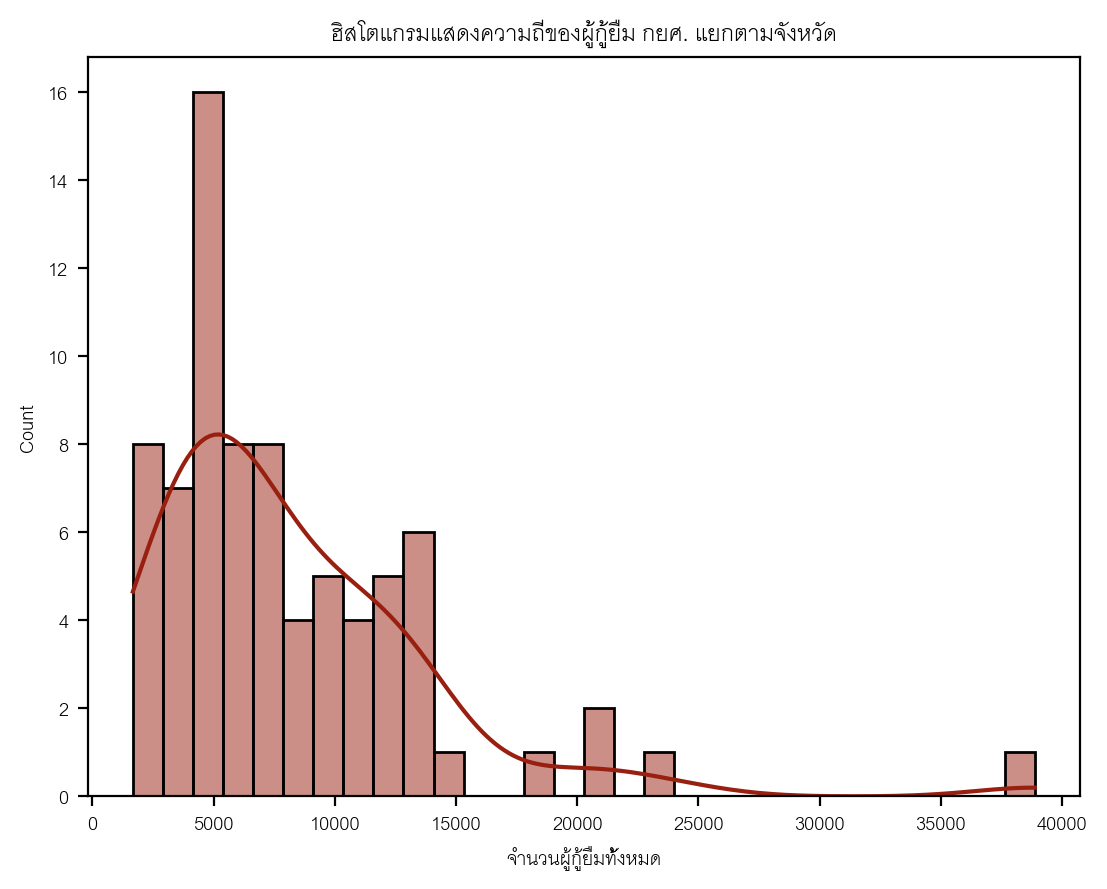

In [89]:
fig1 = sns.histplot(data=summed_df_loan, x="จำนวนผู้กู้ยืมทั้งหมด",kde=True,bins=30, color='#992010')
fig1.set_title('ฮิสโตแกรมแสดงความถี่ของผู้กู้ยืม กยศ. แยกตามจังหวัด')

จากกราฟจะแสดงให้เห็นว่าการกระจายตัวข้อมูลในส่วนของจำนวนผู้กู้ยืม กยศ. มีลักษณะเบ้ขวา และมี Outlier อยู่บ้าง ซึ่งในข้อมูลนั้น จังหวัดที่เป็น Outlier คือจังหวัดกรุงเทพมหานคร

In [40]:
fin_df_loan = summed_df_loan.iloc[:,[0,1,5]].sort_values('จำนวนผู้กู้ยืมทั้งหมด',ascending = False)
fin_df_loan

,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,ผลรวมการกู้
1,กรุงเทพมหานคร,38874,"2,708,539,662.0"
19,นครศรีธรรมราช,23932,"1,333,102,925.0"
18,นครราชสีมา,20827,"1,186,682,777.0"
50,สงขลา,20639,"1,141,742,826.0"
68,อุบลราชธานี,18295,"988,397,273.0"
...,...,...,...
15,นครนายก,2159,"127,500,917.0"
13,ตราด,1902,"109,601,268.0"
41,ระนอง,1822,"100,106,799.0"
53,สมุทรสงคราม,1679,"96,740,331.0"


จากตารางจะเห็นได้เลยว่า

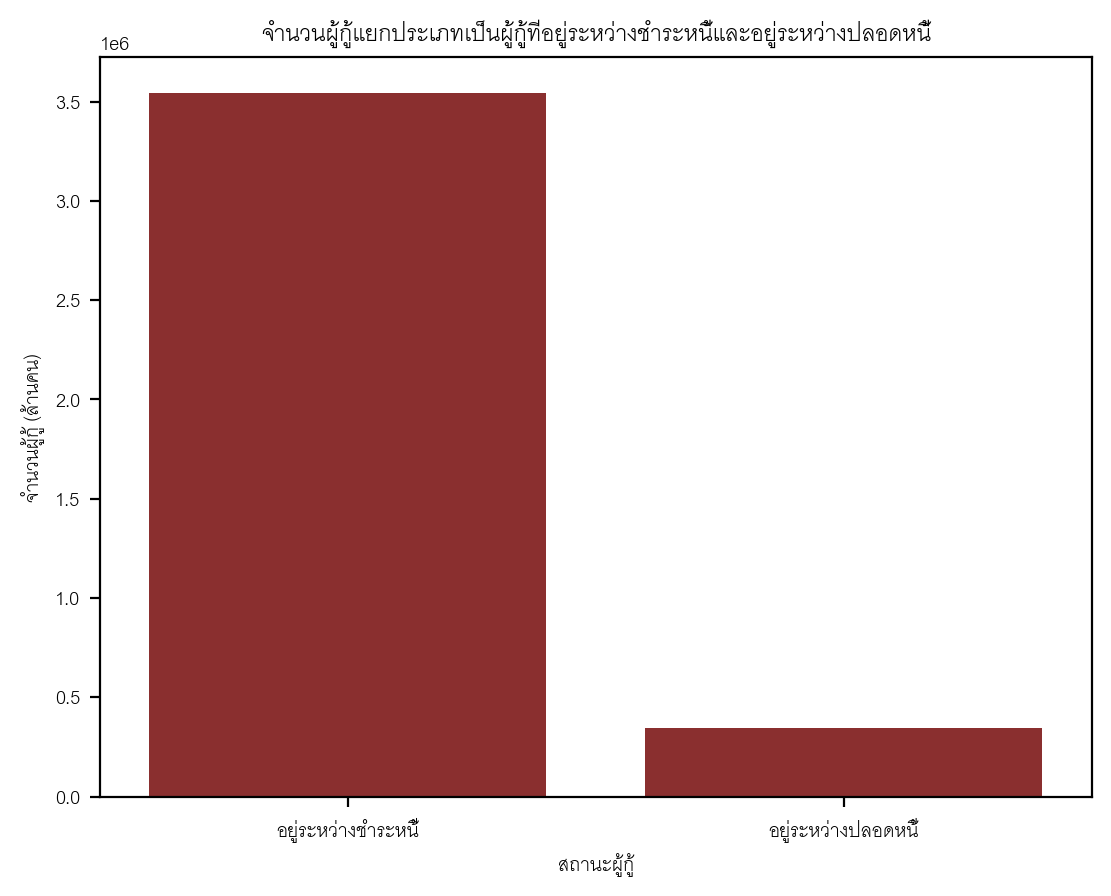

In [115]:
sns.barplot(data = summed_df_payer,x='สถานะผู้กู้',y='จำนวนผู้กู้', color="#992020")
plt.title('จำนวนผู้กู้แยกประเภทเป็นผู้กู้ที่อยู่ระหว่างชำระหนี้และอยู่ระหว่างปลอดหนี้')
plt.xlabel('สถานะผู้กู้')
plt.ylabel('จำนวนผู้กู้ (ล้านคน)')

plt.show()

In [87]:

def update_plot(selected_province):
    filtered_df = grouped_df_payer[grouped_df_payer['จังหวัด'] == selected_province]
    
    borrowers_df = filtered_df.groupby('สถานะผู้กู้')['จำนวนผู้กู้'].sum().reset_index()
    
    amount_owned_df = filtered_df.groupby('สถานะผู้กู้')['จำนวนเงินกู้'].sum().reset_index()
    
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1) # (rows, columns, panel number)
    sns.barplot(x='สถานะผู้กู้', y='จำนวนผู้กู้', data=borrowers_df)
    plt.title(f'จำนวน {selected_province}')
    plt.xlabel('Borrower Status')
    plt.ylabel('Total Number of Borrowers')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='สถานะผู้กู้', y='จำนวนเงินกู้', data=amount_owned_df, color='#992020')
    plt.title(f'Total Amount Owned in {selected_province}')
    plt.xlabel('Borrower Status')
    plt.ylabel('Total Amount Owned')
    
    plt.tight_layout()
    plt.show()
province_dropdown = widgets.Dropdown(
    options=grouped_df_payer['จังหวัด'].unique(),
    description='Province:',
    disabled=False,
)

widgets.interactive(update_plot, selected_province=province_dropdown)

interactive(children=(Dropdown(description='Province:', options=('กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬส…

In [70]:
df_status = df_status[['สถานะผู้กู้ยืม','จำนวนผู้กู้ยืม(รายบัญชี)']]
df_default_rate = df_status.iloc[[2,3], :]

# Calculate the total
total = df_default_rate['จำนวนผู้กู้ยืม(รายบัญชี)'].sum()

# Calculate the percentage for each row
df_default_rate['Percentage'] = (df_default_rate['จำนวนผู้กู้ยืม(รายบัญชี)'] / total) * 100
df_default_rate

C:\Users\Purachai\AppData\Local\Temp\ipykernel_14852\3971100967.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_default_rate['Percentage'] = (df_default_rate['จำนวนผู้กู้ยืม(รายบัญชี)'] / total) * 100


,สถานะผู้กู้ยืม,จำนวนผู้กู้ยืม(รายบัญชี),Percentage
2,2.1ไม่ผิดนัดชำระหนี้,1277319,36.29610222658059
3,2.2ผิดนัดชำระหนี้,2241844,63.70389777341941


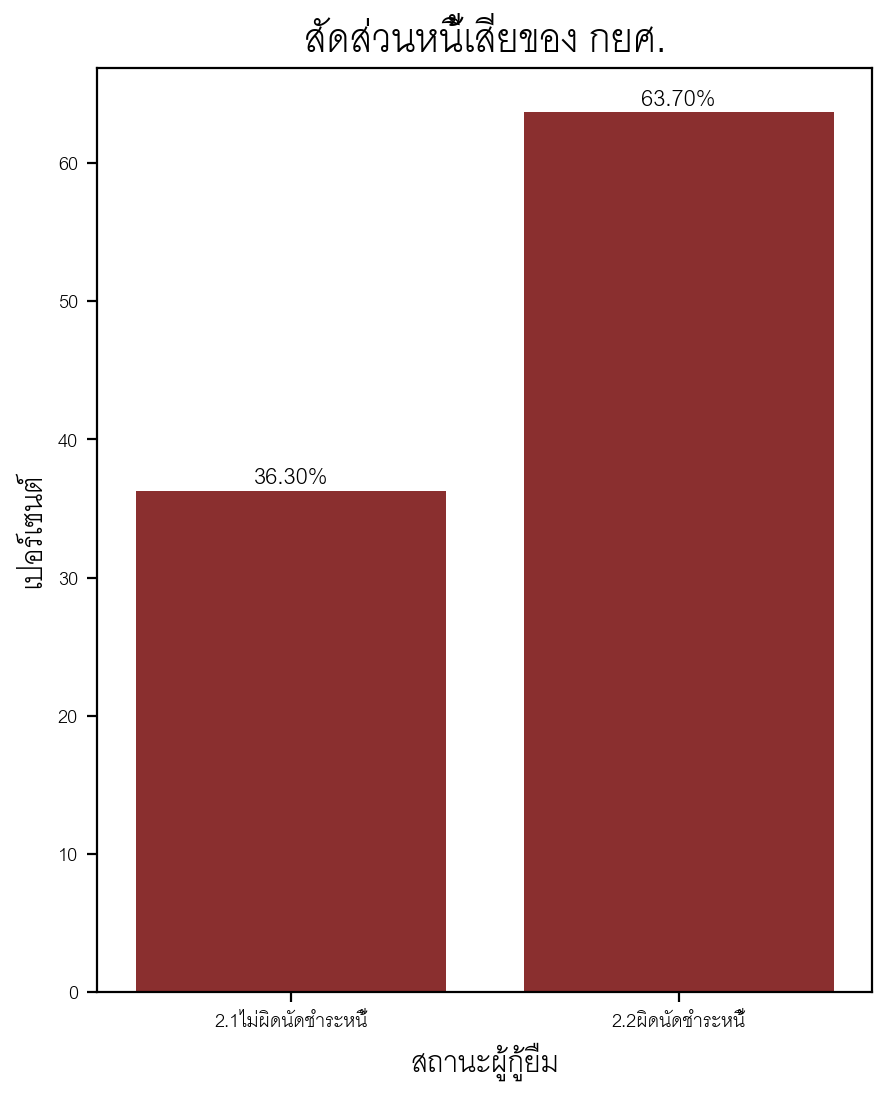

In [88]:
plt.figure(figsize=(5, 6))
fig3 = sns.barplot(data = df_default_rate.iloc[: , [0,2]], x = 'สถานะผู้กู้ยืม', y = 'Percentage', color="#992020" )
ax = plt.gca()
fig3.set_title ('สัดส่วนหนี้เสียของ กยศ.', fontsize = 20)
fig3.set_xlabel('สถานะผู้กู้ยืม', fontsize = 15)
fig3.set_ylabel('เปอร์เซนต์', fontsize = 15)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{height:.2f}%', ha="center",fontsize = 12)

plt.show()

<img src="https://www.studentloan.or.th/sites/default/files/images/news/%E0%B8%82%E0%B9%88%E0%B8%B2%E0%B8%A7.jpg" alt="news" width="800"/>
